In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

# Single RNN from Scratch

In [2]:
class SingleRNN(nn.Module):
    def __init__(self, n_inputs, n_neurons):
        super(SingleRNN, self).__init__()
        
        self.Wx = torch.randn(n_inputs, n_neurons) # 4 X 1
        self.Wy = torch.randn(n_neurons, n_neurons) # 1 X 1
        
        self.b = torch.zeros(1, n_neurons) # 1 X 4
    
    def forward(self, X0, X1):
        self.Y0 = torch.tanh(torch.mm(X0, self.Wx) + self.b) # 4 X 1
        
        self.Y1 = torch.tanh(torch.mm(self.Y0, self.Wy) +
                            torch.mm(X1, self.Wx) + self.b) # 4 X 1
        
        return self.Y0, self.Y1

In [3]:
N_INPUT = 4
N_NEURONS = 1

X0_batch = torch.tensor([[0,1,2,0], [3,4,5,0], 
                         [6,7,8,0], [9,0,1,0]],
                        dtype = torch.float) #t=0 => 4 X 4

X1_batch = torch.tensor([[9,8,7,0], [0,0,0,0], 
                         [6,5,4,0], [3,2,1,0]],
                        dtype = torch.float) #t=1 => 4 X 4

model = SingleRNN(N_INPUT, N_NEURONS)

Y0_val, Y1_val = model(X0_batch, X1_batch)

In [20]:
print(Y0_val, Y1_val)

tensor([[-0.9879],
        [-1.0000],
        [-1.0000],
        [-1.0000]]) tensor([[-1.0000],
        [-0.1424],
        [-1.0000],
        [-0.9983]])


# RNN Cell in Pytorch

In [6]:
rnn = nn.RNNCell(3, 5) # n_input X n_neurons

X_batch = torch.tensor([[[0,1,2], [3,4,5], 
                         [6,7,8], [9,0,1]],
                        [[9,8,7], [0,0,0], 
                         [6,5,4], [3,2,1]]
                       ], dtype = torch.float) # X0 and X1

hx = torch.randn(4, 5) # m X n_neurons
output = []

# for each time step
for i in range(2):
    hx = rnn(X_batch[i], hx)
    output.append(hx)

print(output)

[tensor([[-0.0235,  0.2791,  0.7218,  0.0437,  0.8893],
        [ 0.8122, -0.6874,  0.8898, -0.7031,  0.9995],
        [ 0.9211, -0.9363,  0.9258, -0.7683,  1.0000],
        [ 0.9388, -0.9477,  0.4802, -0.9488,  0.9743]], grad_fn=<TanhBackward>), tensor([[ 0.9422, -0.9865,  0.9351, -0.9765,  1.0000],
        [-0.2446, -0.0297, -0.3572,  0.1599,  0.5859],
        [ 0.7738, -0.9227,  0.7004, -0.8404,  0.9997],
        [ 0.1519, -0.5688,  0.0536, -0.1870,  0.9466]], grad_fn=<TanhBackward>)]


In [7]:
class CleanBasicRNN(nn.Module):
    def __init__(self, batch_size, n_inputs, n_neurons):
        super(CleanBasicRNN, self).__init__()
        
        self.rnn = nn.RNNCell(n_inputs, n_neurons)
        self.hx = torch.randn(batch_size, n_neurons) # initialize hidden state
        
    def forward(self, X):
        output = []

        # for each time step
        for i in range(2):
            self.hx = self.rnn(X[i], self.hx)
            output.append(self.hx)
        
        return output, self.hx

FIXED_BATCH_SIZE = 4 # our batch size is fixed for now
N_INPUT = 3
N_NEURONS = 5

X_batch = torch.tensor([[[0,1,2], [3,4,5], 
                         [6,7,8], [9,0,1]],
                        [[9,8,7], [0,0,0], 
                         [6,5,4], [3,2,1]]
                       ], dtype = torch.float) # X0 and X1


model = CleanBasicRNN(FIXED_BATCH_SIZE, N_INPUT, N_NEURONS)
output_val, states_val = model(X_batch)
print(output_val) # contains all output for all timesteps
print(states_val) # contains values for final state or final timestep, i.e., t=1


[tensor([[ 0.2129, -0.3018,  0.8502, -0.0713,  0.1822],
        [ 0.9216, -0.9979,  0.9940, -0.1003, -0.8683],
        [ 0.8939, -1.0000,  1.0000,  0.9345, -0.8177],
        [-0.8913, -0.9817, -0.2938,  0.9804,  0.1526]], grad_fn=<TanhBackward>), tensor([[ 0.9100, -1.0000,  0.9998,  0.9852, -0.9721],
        [ 0.2527,  0.1310,  0.9074,  0.4671, -0.1208],
        [ 0.4677, -0.9996,  0.9970,  0.9853, -0.7617],
        [-0.0016, -0.9142,  0.5822,  0.9455, -0.7400]], grad_fn=<TanhBackward>)]
tensor([[ 0.9100, -1.0000,  0.9998,  0.9852, -0.9721],
        [ 0.2527,  0.1310,  0.9074,  0.4671, -0.1208],
        [ 0.4677, -0.9996,  0.9970,  0.9853, -0.7617],
        [-0.0016, -0.9142,  0.5822,  0.9455, -0.7400]], grad_fn=<TanhBackward>)


# Using RNN on MNSIT Data

In [8]:
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64

# list all transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

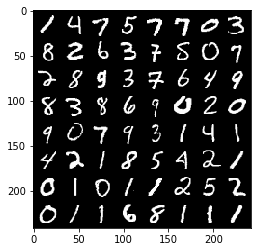

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [12]:
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

# Image RNN in Pytorch

In [13]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [14]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[-0.0854,  0.0388,  0.0209, -0.0541, -0.0323,  0.0088,  0.1579,  0.0551,
         -0.0658,  0.0996],
        [-0.0835,  0.0352,  0.0230, -0.0514, -0.0340,  0.0060,  0.1596,  0.0542,
         -0.0590,  0.0993],
        [-0.0866,  0.0329,  0.0319, -0.0487, -0.0346,  0.0040,  0.1610,  0.0602,
         -0.0554,  0.0989],
        [-0.0797,  0.0387,  0.0195, -0.0525, -0.0256,  0.0105,  0.1548,  0.0416,
         -0.0505,  0.0994],
        [-0.0983,  0.0283,  0.0384, -0.0487, -0.0260, -0.0060,  0.1910,  0.0713,
         -0.0435,  0.1210],
        [-0.0727,  0.0540,  0.0266, -0.0536, -0.0152,  0.0072,  0.1637,  0.0513,
         -0.0512,  0.1151],
        [-0.0846,  0.0327,  0.0198, -0.0440, -0.0323,  0.0112,  0.1561,  0.0670,
         -0.0693,  0.1070],
        [-0.0901,  0.0454,  0.0306, -0.0500, -0.0380,  0.0024,  0.1647,  0.0472,
         -0.0500,  0.1026],
        [-0.0896,  0.0353,  0.0180, -0.0538, -0.0244,  0.0031,  0.1636,  0.0564,
         -0.0553,  0.1059],
        [-0.1061,  

In [17]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [18]:

for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.7619 | Train Accuracy: 74.77
Epoch:  1 | Loss: 0.3117 | Train Accuracy: 91.02
Epoch:  2 | Loss: 0.2327 | Train Accuracy: 93.33
Epoch:  3 | Loss: 0.1929 | Train Accuracy: 94.65
Epoch:  4 | Loss: 0.1720 | Train Accuracy: 95.19
Epoch:  5 | Loss: 0.1469 | Train Accuracy: 95.92
Epoch:  6 | Loss: 0.1358 | Train Accuracy: 96.23
Epoch:  7 | Loss: 0.1292 | Train Accuracy: 96.39
Epoch:  8 | Loss: 0.1276 | Train Accuracy: 96.49
Epoch:  9 | Loss: 0.1124 | Train Accuracy: 96.94


In [19]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 96.61
